In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import math
sns.set(font_scale=1.2)
from sklearn.model_selection import KFold, cross_val_score
S = 1
# S = (4500000)/4/(2**23-1) #uV/count

In [181]:
# Read data

def read_raw_data(subject):
    df_1 = pd.read_csv(subject + 'data_1\\trials.txt', header=4)
    events_df_1 = pd.read_csv(subject + 'data_1\\events.txt', header=None)

    df_2 = pd.read_csv(subject + 'data_2\\trials.txt', header=4)
    events_df_2 = pd.read_csv(subject + 'data_2\\events.txt', header=None)

    df_3 = pd.read_csv(subject + 'data_3\\trials.txt', header=4)
    events_df_3 = pd.read_csv(subject + 'data_3\\events.txt', header=None)
    
    df_1 = df_1[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' Timestamp']]
    df_2 = df_2[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' Timestamp']]
    df_3 = df_3[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' Timestamp']]
    
    df_1 = df_1.rename(columns={" EXG Channel 0":"Fp1", " EXG Channel 1":"Fp2", " EXG Channel 2":"C3", " EXG Channel 3":"C4", " EXG Channel 4":"P3", " EXG Channel 5":"P4", " EXG Channel 6":"O1", " EXG Channel 7":"O2"})
    df_2 = df_2.rename(columns={" EXG Channel 0":"Fp1", " EXG Channel 1":"Fp2", " EXG Channel 2":"C3", " EXG Channel 3":"C4", " EXG Channel 4":"P3", " EXG Channel 5":"P4", " EXG Channel 6":"O1", " EXG Channel 7":"O2"})
    df_3 = df_3.rename(columns={" EXG Channel 0":"Fp1", " EXG Channel 1":"Fp2", " EXG Channel 2":"C3", " EXG Channel 3":"C4", " EXG Channel 4":"P3", " EXG Channel 5":"P4", " EXG Channel 6":"O1", " EXG Channel 7":"O2"})
    
    events_1 = events_df_1.to_numpy()
    events_2 = events_df_2.to_numpy()
    events_3 = events_df_3.to_numpy()
    
    data_1 = df_1.to_numpy()
    data_2 = df_2.to_numpy()
    data_3 = df_3.to_numpy()
    
    eeg_data_1 = data_1[:,:8]
    eeg_data_2 = data_2[:,:8]
    eeg_data_3 = data_3[:,:8]
    
    time_stamp_1 = data_1[:, 8]
    time_stamp_2 = data_2[:, 8]
    time_stamp_3 = data_3[:, 8]
    
    return eeg_data_1, eeg_data_2, eeg_data_3, events_1, events_2, events_3, time_stamp_1, time_stamp_2, time_stamp_3

In [182]:
# Subject 1, three trial data
sub_1_eeg_data_1, sub_1_eeg_data_2, sub_1_eeg_data_3, sub_1_events_1, sub_1_events_2, sub_1_events_3, sub_1_time_stamp_1, sub_1_time_stamp_2, sub_1_time_stamp_3 = read_raw_data('K:/OneDrive - iitkgp.ac.in/PhD/Codes/Bi_Color/Data/subject_1/')

In [183]:
# Subject 2, three trial data
sub_2_eeg_data_1, sub_2_eeg_data_2, sub_2_eeg_data_3, sub_2_events_1, sub_2_events_2, sub_2_events_3, sub_2_time_stamp_1, sub_2_time_stamp_2, sub_2_time_stamp_3 = read_raw_data('K:/OneDrive - iitkgp.ac.in/PhD/Codes/Bi_Color/Data/subject_2/')

In [184]:
# Check the dimentions of the data

print(sub_1_eeg_data_1.shape)
print(sub_1_events_1.shape)
print(sub_1_time_stamp_1.shape)
print('-----------------------')
print(sub_2_eeg_data_1.shape)
print(sub_2_events_1.shape)
print(sub_2_time_stamp_1.shape)

(108582, 8)
(102, 2)
(108582,)
-----------------------
(99196, 8)
(102, 2)
(99196,)


In [186]:
# Scaling Data with the scale factor S = (4500000)/4/(2**23-1)

sub_1_scaled_data_1 = sub_1_eeg_data_1*S
sub_1_scaled_data_2 = sub_1_eeg_data_2*S
sub_1_scaled_data_3 = sub_1_eeg_data_3*S

sub_2_scaled_data_1 = sub_2_eeg_data_1*S
sub_2_scaled_data_2 = sub_2_eeg_data_2*S
sub_2_scaled_data_3 = sub_2_eeg_data_3*S

In [187]:
# Notch filter

def notch_filter(data,samp_freq=256,notch_freq=50,quality_factor=20):
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    freq, h = signal.freqz(b_notch, a_notch, fs=samp_freq)
    outputSignal = signal.filtfilt(b_notch, a_notch, data)
    return outputSignal


def data_on_notch_filter(data):
    notched_data = np.zeros((8,data.shape[0]))

    for i,channel in enumerate(data.T):
        notched_data[i] = notch_filter(data.T[i],256,50,20)

    return notched_data.T

In [188]:
# Applying notch filter

notched_sub_1_data_1 = data_on_notch_filter(sub_1_scaled_data_1)
notched_sub_1_data_2 = data_on_notch_filter(sub_1_scaled_data_2)
notched_sub_1_data_3 = data_on_notch_filter(sub_1_scaled_data_3)
notched_sub_2_data_1 = data_on_notch_filter(sub_2_scaled_data_1)
notched_sub_2_data_2 = data_on_notch_filter(sub_2_scaled_data_2)
notched_sub_2_data_3 = data_on_notch_filter(sub_2_scaled_data_3)

print(notched_sub_1_data_1.shape)
print(notched_sub_1_data_2.shape)
print(notched_sub_1_data_3.shape)
print('------------------')
print(notched_sub_2_data_1.shape)
print(notched_sub_2_data_2.shape)
print(notched_sub_2_data_3.shape)

(108582, 8)
(107956, 8)
(94452, 8)
------------------
(99196, 8)
(114782, 8)
(95558, 8)


In [189]:
# Bandpass filter

from scipy.signal import butter, lfilter

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def data_on_bandpass_filter(data):   
    data_preprocessed_1 = np.zeros((8,data.shape[0]))
    for i,channel in enumerate(data.T):
        data_preprocessed_1[i] = butter_bandpass_filter(data.T[i], 0.5,40,256, order=6)

    return data_preprocessed_1.T

In [190]:
# Applying bandpass filter

band_sub_1_data_1 = data_on_bandpass_filter(notched_sub_1_data_1)
band_sub_1_data_2 = data_on_bandpass_filter(notched_sub_1_data_2)
band_sub_1_data_3 = data_on_bandpass_filter(notched_sub_1_data_3)
band_sub_2_data_1 = data_on_bandpass_filter(notched_sub_2_data_1)
band_sub_2_data_2 = data_on_bandpass_filter(notched_sub_2_data_2)
band_sub_2_data_3 = data_on_bandpass_filter(notched_sub_2_data_3)

print(band_sub_1_data_1.shape)
print(band_sub_1_data_2.shape)
print(band_sub_1_data_3.shape)
print('------------------')
print(band_sub_2_data_1.shape)
print(band_sub_2_data_2.shape)
print(band_sub_2_data_3.shape)

(108582, 8)
(107956, 8)
(94452, 8)
------------------
(99196, 8)
(114782, 8)
(95558, 8)


In [191]:
print("Raw Filtered Data:\n", sub_1_eeg_data_1)
print("Scaled Filtered Data:\n", sub_1_scaled_data_1)
print("Notched Filtered Data:\n", notched_sub_1_data_1)
print("Bandpass Filtered Data:\n", band_sub_1_data_1)

Bandpass Filtered Data:
 [[ 2.40789727e-01  2.41676409e-01 -9.87509131e-01 ... -2.52386190e-01
  -1.10623868e-01 -3.98078108e-01]
 [-4.82700333e+02 -4.86824885e+02 -4.04082863e+02 ... -3.83847138e+02
  -4.45843976e+02 -1.28302292e+03]
 [-4.46843977e+03 -4.50657966e+03 -3.68879708e+03 ... -3.53407762e+03
  -4.11313820e+03 -1.18315611e+04]
 ...
 [-1.23531987e+01 -9.53159978e+00 -6.22082062e+01 ...  3.92068109e-01
  -4.44913571e+01 -4.30156529e+02]
 [-4.93239140e+01 -4.42468292e+01  6.71544618e+01 ...  6.83039812e+01
  -1.35323994e+01 -3.20459846e+02]
 [-6.11301096e+01 -5.42574384e+01  1.15813919e+02 ...  9.23980171e+01
  -5.14725644e+00 -2.50771619e+02]]
Bandpass Filtered Data:
 [[ 2.40789727e-01  2.41676409e-01 -9.87509131e-01 ... -2.52386190e-01
  -1.10623868e-01 -3.98078108e-01]
 [-4.82700333e+02 -4.86824885e+02 -4.04082863e+02 ... -3.83847138e+02
  -4.45843976e+02 -1.28302292e+03]
 [-4.46843977e+03 -4.50657966e+03 -3.68879708e+03 ... -3.53407762e+03
  -4.11313820e+03 -1.18315611e+04]

In [143]:
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return (arr[idx] , idx)

#closest stamps for our dataset
def closest_stamp_values(time_stamps, events):
    closest_stamps_vals = np.zeros(len(events))
    closest_stamps_ids = np.zeros(len(events)) 
    
    event_labels = []
    
    for i in range(len(events)):
        closest_stamps_vals[i] = find_closest(time_stamps, events[i,0])[0]
        closest_stamps_ids[i] = find_closest(time_stamps, events[i,0])[1]
        event_labels.append(events[i,1])
    
    return closest_stamps_vals, closest_stamps_ids, event_labels

def remove_fixation_and_baseline(closest_stamps_ids, event_labels, data):
    session_data =  np.random.randint(100000,900000,(250,250,8))
    rc = 0 # row count 
    markers = []
    for i,image in enumerate(closest_stamps_ids):
        if event_labels[i] == 'red' or event_labels[i] == 'white':
            for j in range(5):
                if event_labels[i] == 'red':
                    markers.append(0)
                if event_labels[i] == 'white':
                    markers.append(1)
                for k in range(250):
                    if int(closest_stamps_ids[i])+j*256+250 > data.shape[0]:
                        break
                    session_data[rc][k] = data[int(closest_stamps_ids[i])+j*256:int(closest_stamps_ids[i])+j*256+250][k]
                rc = rc + 1            
    rc = 0
    return markers,session_data

In [144]:
# Data Epoching

def segmentation(time_stamp, events, data):
    closest_stamps_vals = np.zeros(len(events))
    closest_stamps_ids = np.zeros(len(events))

    event_labels = []

    closest_stamps_vals, closest_stamps_ids, event_labels = closest_stamp_values(time_stamp, events)

    markers, epoched_data = remove_fixation_and_baseline(closest_stamps_ids,event_labels, data)
    markers = np.array(markers)
    
    return epoched_data, markers

In [145]:
# Epoching Data for 2 subjects

# Subject 1
epoched_sub_1_data_1, markers_sub_1_data_1 = segmentation(sub_1_time_stamp_1, sub_1_events_1, sub_1_eeg_data_1)
epoched_sub_1_data_2, markers_sub_1_data_2 = segmentation(sub_1_time_stamp_2, sub_1_events_2, sub_1_eeg_data_2)
epoched_sub_1_data_3, markers_sub_1_data_3 = segmentation(sub_1_time_stamp_3, sub_1_events_3, sub_1_eeg_data_3)

# Subject 2
epoched_sub_2_data_1, markers_sub_2_data_1 = segmentation(sub_2_time_stamp_1, sub_2_events_1, sub_2_eeg_data_1)
epoched_sub_2_data_2, markers_sub_2_data_2 = segmentation(sub_2_time_stamp_2, sub_2_events_2, sub_2_eeg_data_2)
epoched_sub_2_data_3, markers_sub_2_data_3 = segmentation(sub_2_time_stamp_3, sub_2_events_3, sub_2_eeg_data_3)

# printing Data Shapes
print(epoched_sub_1_data_1.shape)
print(markers_sub_1_data_1.shape)
print('----------------')
print(epoched_sub_2_data_1.shape)
print(markers_sub_2_data_1.shape)

(250, 250, 8)
(250,)
----------------
(250, 250, 8)
(250,)


In [146]:
# Concatenate 3 trials data for each subjects

# Subject 1
sub_1_data = np.concatenate((epoched_sub_1_data_1, epoched_sub_1_data_2, epoched_sub_1_data_3), axis=0)
sub_1_markers = np.concatenate((markers_sub_1_data_1, markers_sub_1_data_2, markers_sub_1_data_3), axis=0)

# Subject 2
sub_2_data = np.concatenate((epoched_sub_2_data_1, epoched_sub_2_data_2, epoched_sub_2_data_3), axis=0)
sub_2_markers = np.concatenate((markers_sub_2_data_1, markers_sub_2_data_2, markers_sub_2_data_3), axis=0)

# Printing Data Shapes
print(sub_1_data.shape)
print(sub_1_markers.shape)
print('--------------')
print(sub_2_data.shape)
print(sub_2_markers.shape)

(750, 250, 8)
(750,)
--------------
(750, 250, 8)
(750,)


In [147]:
# from scipy.stats import kurtosis, skew

# def stat_feature(segment):
#     _mean = []
#     _std = []
#     _skewness = []
#     _kurtosis = []

#     for i in range(len(segment)):
#         _mean.append(np.mean(segment[i]))
#         _std.append(np.std(segment[i]))
#         _skewness.append(skew(segment[i]))
#         _kurtosis.append(kurtosis(segment[i]))

#     _mean = np.array(_mean)
#     _std = np.array(_std)
#     _skewness = np.array(_skewness)
#     _kurtosis = np.array(_kurtosis)

#     features = np.concatenate((_mean, _std, _skewness, _kurtosis))

#     return features

In [148]:
# from scipy.fftpack import dct

# def dct_feature(segment):
#     features = []
#     for i in range(len(segment)):
#         dct_coef = dct(segment[i,:], 2, norm='ortho')
#         power = sum( j*j for j in dct_coef)
#         features.append(power)

#     features = np.array(features)
#     return features

# CSP features extraction from scratch

In [158]:
# Creating dict to store original data and modified data
ori_data = dict()
mod_data = dict()

In [159]:
# Create function to print keys() within dictionary
def showKeys(dict_name):
    print('Keys in this dict are: ')
    for i in dict_name.keys():
        print(i)

In [160]:
# number of subject to be processed (n+1 for iteration purpose)
ns = 2

In [161]:
# function to count subject
def subjectCounter(i):
    return 'subject0{}'.format(i)

In [162]:
# Initialize 'subject0x' dict inside mod_data
for i in range(1, ns+1):
    subj = subjectCounter(i)
    mod_data[subj] = {}
    
mod_data

{'subject01': {}, 'subject02': {}}

In [163]:
ori_data['subject01'] = sub_1_data.reshape(750*250, 8).T
ori_data['subject02'] = sub_2_data.reshape(750*250, 8).T

In [164]:
# Peek into different shape of recorded data/'s' between subjects
print('Electrodes\tSample')
for i in range(1, ns+1):
    subj_temp = subjectCounter(i)
    print(ori_data[subj_temp].shape)

Electrodes	Sample
(8, 187500)
(8, 187500)


In [170]:
# First extract the sample data from ori_data into mod_data
for i in range(1, ns+1):
    subj = subjectCounter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj].T

# Bandpass filtering 8-30 Hz

Using FIR [8 30] Hz band-pass filter to remove muscle artifacts, powerline noise, and DC drift
The command fir1 in used in MATLAB which is equivalent to scipy.signal.firwin in python
Next EEG signals between [0.5, 3.5] seconds after cue onset are extracted

In [171]:
from scipy.signal import firwin, freqz, lfilter

In [172]:
# From document freqeuncy sampling at 250 Hz
fs = 250

In [173]:
def fir_bandpass(numtaps, low, high, fs):
    fnyq = fs/2
    b = firwin(numtaps, np.array([low, high])/(fnyq), pass_zero = 'bandpass')
    
    return b 

In [174]:
# This function will apply bandpass filter to raw EEG data
def apply_bandpass(raw_EEG, b):
    '''
    INPUT:
    raw_EEG : EEG data in the shape of S x N
    b : coefficient of band-pass filter
    
    OUTPUT:
    EEG_filtered : filtered EEG data shape S x N
    
    N : number of channel
    S : number of sample
    '''
    raw_EEG = lfilter(b, 1, raw_EEG, axis=0)
    
    return raw_EEG

In [175]:
# Creating band-pass filter
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [176]:
# Applying bandpass

# Key to access data
raw_EEG = 'raw_EEG'

# Key to store result
EEG_filtered = 'EEG_filtered'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_raw_EEG = mod_data[subj][raw_EEG]
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

In [177]:
sub_1_markers

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

In [178]:
# modified_markers_sub_1 = []
# for i,marker in enumerate(sub_1_markers):
#         modified_markers_sub_1+= [sub_1_markers[i]]*250
        
# modified_markers_sub_2 = []
# for i,marker in enumerate(sub_2_markers):
#         modified_markers_sub_2+= [sub_2_markers[i]]*250        

In [179]:
mod_data['subject02']

{'raw_EEG': array([[ 824347,  333998,  522868, ...,  318441,  120391,  170318],
        [ 379580,  251446,  492942, ...,  622769,  809851,  830433],
        [ 428019,  731308,  881707, ...,  810550,  579603,  774556],
        ...,
        [-101642, -109149,  -93108, ..., -124670, -264922, -178185],
        [-101635, -109141,  -93049, ..., -124174, -263962, -177694],
        [-101597, -109114,  -93146, ..., -124576, -264259, -177975]]),
 'EEG_filtered': array([[  796.2639385 ,   322.61967707,   505.05543538, ...,
           307.59265799,   116.28963509,   164.51577003],
        [  648.41312968,   357.04150527,   654.8667885 , ...,
           710.39720048,   823.41178201,   860.35781372],
        [  541.14520485,   791.51537658,  1018.86876083, ...,
           995.01554642,   836.37010124,  1031.59342651],
        ...,
        [ -740.77992576,  -795.99176589,  -676.60491166, ...,
          -914.49933748, -1950.48136672, -1298.53812121],
        [ -741.51495833,  -796.42398814,  -682.8050

# Taking EEG data corresponds to left and right class

Current method of CSP calculation requires EEG red and EEG white data,
thus the goal here is to make EEG red and EEG white class each has dimension T x C x N, where
T = trial, C = channel, N = sample

In [59]:
# First take the position of red and white class
red_pos = 'red_pos'
white_pos = 'white_pos'

mod_data['subject01'][red_pos] = []
mod_data['subject01'][white_pos] = []

for j,_ in enumerate(sub_1_markers):
    if sub_1_markers[j] == 0:
        mod_data['subject01'][red_pos]+= [j]
    else:
        mod_data['subject01'][white_pos]+= [j]
        

        
        
        
mod_data['subject02'][red_pos] = []
mod_data['subject02'][white_pos] = []

for j,_ in enumerate(sub_2_markers):
    if sub_2_markers[j] == 0:
        mod_data['subject02'][red_pos]+= [j]
    else:
        mod_data['subject02'][white_pos]+= [j]        

In [60]:
 np.array(mod_data['subject02'][red_pos]).shape

(375,)

In [61]:
print(len(mod_data[subj][EEG_filtered]),len(mod_data[subj][EEG_filtered][0]))

187500 8


In [62]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.0
end = 1.0

# Key to access data
EEG_filtered = 'EEG_filtered'

# Key to store result
EEG_red = 'EEG_red'
EEG_white = 'EEG_white'

for i in range(1, ns+1):
    subj = subjectCounter(i)
        
    # Temporary variable of left and right pos    
    temp_pos_red = mod_data[subj][red_pos]
    temp_pos_white = mod_data[subj][white_pos]

    temp_EEG_red = []
    temp_EEG_white = []
    
    # LEFT
    for j in range(len(temp_pos_red)):
        if (temp_pos_red[j] + int(end*fs)) <= len(mod_data[subj][EEG_filtered]):
            temp_EEG_red.append(mod_data[subj][EEG_filtered]\
                             [temp_pos_red[j] + int(start*fs) : temp_pos_red[j] + int(end*fs)].T)
        else:
            temp_EEG_red.append(mod_data[subj][EEG_filtered]\
                             [temp_pos_red[j] + int(start*fs) :].T)
            
    mod_data[subj][EEG_red] = temp_EEG_red
    
    # RIGHT
    for j in range(len(temp_pos_white)):
        if (temp_pos_red[j] + int(end*fs)) <= len(mod_data[subj][EEG_filtered]):
                temp_EEG_white.append(mod_data[subj][EEG_filtered]\
                              [temp_pos_white[j] + int(start*fs) : temp_pos_white[j] + int(end*fs)].T)
        else:
             temp_EEG_white.append(mod_data[subj][EEG_filtered]\
                              [temp_pos_white[j] + int(start*fs) :].T)
                
    mod_data[subj][EEG_white] = temp_EEG_white


In [63]:
print(mod_data['subject01'][EEG_red])

[array([[ -158.50187142,  -214.63730967,  -214.43689972, ...,
        -1188.6194829 , -1183.66192143, -1179.161695  ],
       [ -159.43979232,  -215.91484878,  -215.71477734, ...,
        -1199.40225046, -1201.83156628, -1202.78025821],
       [ -132.0884346 ,  -178.90238346,  -177.94666491, ...,
         -977.09709961,  -988.41511121, -1000.4866232 ],
       ...,
       [ -117.61006545,  -159.26402335,  -158.75055007, ...,
         -880.43557637,  -882.27377986,  -885.32554484],
       [ -129.73059224,  -175.62616375,  -175.18572201, ...,
         -968.58607567,  -968.10597336,  -968.87469128],
       [ -244.00915491,  -330.50827478,  -329.61605731, ...,
        -1777.45502511, -1779.83786164, -1784.59520196]]), array([[ -214.63730967,  -214.43689972,  -264.60408303, ...,
        -1183.66192143, -1179.161695  , -1177.63607752],
       [ -215.91484878,  -215.71477734,  -266.17288216, ...,
        -1201.83156628, -1202.78025821, -1202.98244555],
       [ -178.90238346,  -177.94666491,  

In [64]:
# Checking if raw EEG contains NaN
isnan = []
for i in range(1, ns+1):
    subj = subjectCounter(i)
    temp = np.isnan(mod_data[subj]['raw_EEG'])
    isnan.append(np.sum(temp))
    
isnan

[0, 0]

In [65]:
# Checking current size of EEG red and white data
print('\t\tred \t\t white')

for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, (len(temp['EEG_red']),len(temp['EEG_red'][1]),len(temp['EEG_red'][1][1])), (len(temp['EEG_white']),len(temp['EEG_white'][1]),len(temp['EEG_white'][1][1]))))

		red 		 white
subject01:	(375, 8, 250)	(375, 8, 250)
subject02:	(375, 8, 250)	(375, 8, 250)


# Split into test and train data

In [66]:
def split_EEG_one_class(EEG_one_class, EEG_one_class_pos, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number
    
    INPUT:
    EEG_data_one_class: the data of one class of EEG data
    
    percent_train: allocation percentage of training data, default is 0.8
    
    OUTPUT:
    EEG_train: EEG data for training
    
    EEG_test: EEG data for test
    
    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = len(EEG_one_class)
    
    n_tr = round(n*percent_train)
    n_te = n - n_tr
    
    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]
    
    EEG_train_pos = EEG_one_class_pos[:n_tr]
    EEG_test_pos = EEG_one_class_pos[n_tr:n_tr+n_te]
    
    return EEG_train, EEG_test, EEG_train_pos, EEG_test_pos

In [67]:
# Keys to access data
EEG_red = 'EEG_red'
EEG_white = 'EEG_white'

# Keys to store result
EEG_red_train = 'EEG_red_train'
EEG_white_train = 'EEG_white_train'

EEG_red_test = 'EEG_red_test'
EEG_white_test = 'EEG_white_test'

EEG_red_pos_train = 'EEG_red_pos_train'
EEG_white_pos_train = 'EEG_white_pos_train'

EEG_red_pos_test = 'EEG_red_pos_test'
EEG_white_pos_test = 'EEG_white_pos_test'

for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    
    mod_data[subj][EEG_red_train], mod_data[subj][EEG_red_test], mod_data[subj][EEG_red_pos_train], mod_data[subj][EEG_red_pos_test] = split_EEG_one_class(mod_data[subj][EEG_red],mod_data[subj][red_pos], 0.8)
    mod_data[subj][EEG_white_train], mod_data[subj][EEG_white_test], mod_data[subj][EEG_white_pos_train], mod_data[subj][EEG_white_pos_test] = split_EEG_one_class(mod_data[subj][EEG_white],mod_data[subj][white_pos], 0.8)   

In [68]:
mod_data['subject01']['EEG_white_pos_train'][1]

11

In [69]:
# Checking size of EEG red_pos and white_pos data training and test data
print('\t\tred \t\t white')
print('TRAINING')
for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t\t{}'.format(i, (len(temp['EEG_red_pos_train'])), (len(temp['EEG_white_pos_train']))))

print('TEST')
for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t\t{}'.format(i, (len(temp['EEG_red_pos_test'])), (len(temp['EEG_white_pos_test']))))

		red 		 white
TRAINING
subject01:	300		300
subject02:	300		300
TEST
subject01:	75		75
subject02:	75		75


In [70]:
# Checking size of EEG red and white data training and test data
print('\t\tred \t\t white')
print('TRAINING')
for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, (len(temp['EEG_red_train']),len(temp['EEG_red_train'][1]),len(temp['EEG_red_train'][1][1])), (len(temp['EEG_white_train']),len(temp['EEG_white_train'][1]),len(temp['EEG_white_train'][1][1]))))

print('TEST')
for i in range(1, ns+1):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, (len(temp['EEG_red_test']),len(temp['EEG_red_test'][1]),len(temp['EEG_red_test'][1][1])), (len(temp['EEG_white_test']),len(temp['EEG_white_test'][1]),len(temp['EEG_white_test'][1][1]))))

		red 		 white
TRAINING
subject01:	(300, 8, 250)	(300, 8, 250)
subject02:	(300, 8, 250)	(300, 8, 250)
TEST
subject01:	(75, 8, 250)	(75, 8, 250)
subject02:	(75, 8, 250)	(75, 8, 250)


# CSP

In [71]:
# For all subject create new keys to store all result in CSP step
for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP'] = {}

# Covariance and Composite Covariance


In [72]:
def compute_cov(EEG_data):
    '''
    INPUT:
    EEG_data : EEG_data in shape T x N x S
    
    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    '''
    cov = []
    for i in range(len(EEG_data)):
        cov.append(EEG_data[i]@EEG_data[i].T/np.trace(EEG_data[i]@EEG_data[i].T))
        
    cov = np.mean(np.array(cov), 0)
    
    return cov

In [73]:
# Key to access data
EEG_red_train = 'EEG_red_train'
EEG_white_train = 'EEG_white_train'

# Key to store data
CSP = 'CSP'
cov_red = 'cov_red'
cov_white = 'cov_white'
cov_comp = 'cov_comp'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    # New key to store result
    temp_CSP = mod_data[subj][CSP]
    
    # LEFT
    temp_CSP[cov_red] = compute_cov(mod_data[subj][EEG_red_train])

    # RIGHT
    temp_CSP[cov_white] = compute_cov(mod_data[subj][EEG_white_train])
    
    # Add covariance of left and right class as composite covariance
    temp_CSP[cov_comp] = temp_CSP[cov_red] + temp_CSP[cov_white]

In [74]:
print(len(temp_CSP[cov_comp]),len(temp_CSP[cov_comp][0]))

8 8


In [75]:
print(len(temp_CSP[cov_white]),len(temp_CSP[cov_white][0]))

8 8


In [76]:
print(len(temp_CSP[cov_red]),len(temp_CSP[cov_red][0]))

8 8


# White Matrix (P)

In [77]:
# Create new keys for result in whitening step
for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP']['whitening'] = {}

In [78]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

In [79]:
def decompose_cov(avg_cov):
    '''
    This function will decompose average covariance matrix of one class of each subject into 
    eigenvalues denoted by lambda and eigenvector denoted by V
    Both will be in descending order
    
    Parameter:
    avgCov = the averaged covariance of one class
    
    Return:
    λ_dsc and V_dsc, i.e. eigenvalues and eigenvector in descending order
    
    '''
    λ, V = np.linalg.eig(avg_cov)
    λ_dsc = np.sort(λ)[::-1] # Sort eigenvalue descending order, default is ascending order sort
    idx_dsc = np.argsort(λ)[::-1] # Find index in descending order
    V_dsc = V[:, idx_dsc] # Sort eigenvectors descending order
    λ_dsc = np.diag(λ_dsc) # Diagonalize λ_dsc
    
    return λ_dsc, V_dsc

In [80]:
def white_matrix(λ_dsc, V_dsc):
    '''
    '''
    λ_dsc_sqr = sqrtm(inv(λ_dsc))
    P = (λ_dsc_sqr)@(V_dsc.T)
    
    return P

In [81]:
# Keys to access data
whitening = 'whitening'
cov_comp = 'cov_comp'

# Keys to store result
eigval = 'eigval'
eigvec = 'eigvec'
P = 'P'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_whitening = mod_data[subj][CSP][whitening]
    
    temp_cov = mod_data[subj][CSP][cov_comp]
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening[eigval], temp_whitening[eigvec] = decompose_cov(temp_cov)
    
    # White matrix
    temp_whitening[P] = white_matrix(temp_whitening[eigval], temp_whitening[eigvec])

In [82]:
print(len(temp_whitening[P]),len(temp_whitening[P][0]))

8 8


# Common Eigenvec from Sl and Sr

In [83]:
# Create new keys for result in decomposing Sl and Sr
for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP']['S_red'] = {}
    mod_data[subj]['CSP']['S_white'] = {}      

In [84]:
def compute_S(avg_Cov, white):
    '''
    This function will compute S matrix, S = P * C * P.T

    INPUT:
    avg_Cov: averaged covariance of one class, dimension N x N, where N is number of electrodes
    white: the whitening transformation matrix
    
    OUTPUT:
    S
    '''
    S = white@avg_Cov@white.T
    
    return S

In [85]:
def decompose_S(S_one_class, order='descending'):
    '''
    This function will decompose the S matrix of one class to get the eigen vector
    Both eigenvector will be the same but in opposite order
    
    i.e the highest eigenvector in S left will be equal to lowest eigenvector in S right matrix 
    '''
    # Decompose S
    λ, B = np.linalg.eig(S_one_class)
    
    # Sort eigenvalues either descending or ascending
    if order == 'ascending':
        idx = λ.argsort() # Use this index to sort eigenvector smallest -> largest
    elif order == 'descending':
        idx = λ.argsort()[::-1] # Use this index to sort eigenvector largest -> smallest
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

In [86]:
# Keys to access data
P = 'P'
cov_red = 'cov_red'
cov_white = 'cov_white'
CSP = 'CSP'

# Keys to store data
S_red = 'S_red'
S_white = 'S_white'
eigvec = 'eigvec'
eigval = 'eigval'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    # Where to access data
    temp_P = mod_data[subj][CSP][whitening][P]
    Cl = mod_data[subj][CSP][cov_red]
    Cr = mod_data[subj][CSP][cov_white]
    
    # Where to store result
    temp_Sl = mod_data[subj][CSP][S_red]
    temp_Sr = mod_data[subj][CSP][S_white]

    # LEFT
    Sl = compute_S(Cl, temp_P)
    temp_Sl[eigvec], temp_Sl[eigval] = decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = compute_S(Cr, temp_P)
    temp_Sr[eigvec], temp_Sr[eigval] = decompose_S(Sr, 'ascending')   

In [87]:
temp_ = temp_Sl[eigval] + temp_Sr[eigval]

In [88]:
temp_

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [89]:
print(len(temp_Sl[eigval]))

8


# Spatial Filter (W)

In [90]:
def spatial_filter(B, P):
    '''
    Will compute projection matrix using the following equation:
    W = B' @ P
    
    INPUT:
    B: the eigenvector either left or right class, choose one, size N x N, N is number of electrodes
    P: white matrix in size of N x N 
    
    OUTPUT:
    W spatial filter to filter EEG
    '''
    
    return (B.T@P)

In [91]:
# Key to access data
CSP = 'CSP'
eigvec = 'eigvec'
S_left = 'S_white'
P = 'P'

# Key to store variable
W = 'W'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_eigvec = mod_data[subj][CSP][S_red][eigvec]
    temp_P = mod_data[subj][CSP][whitening][P]
    
    mod_data[subj][CSP][W] = spatial_filter(temp_eigvec, temp_P)

In [92]:
mod_data[subj][CSP][W]

array([[ 1.09033715, -0.12512497, -0.00975029,  0.54277157,  0.84802861,
         0.42772557,  1.02792497,  0.85685858],
       [-0.51827621,  1.62725126,  0.97941149, -0.12400814,  0.37127829,
        -0.4624875 ,  0.97540915, -0.43787607],
       [-0.04586357,  0.5274589 , -0.46494927,  1.1520874 ,  0.8389289 ,
        -0.25734017, -0.44842565, -0.90049571],
       [-0.43619829, -0.37463774,  0.30256912,  0.30676721,  0.26297591,
        -1.6150672 , -0.48486762,  0.85122272],
       [ 0.90911765, -0.22495546,  0.14579267,  0.04020818, -1.04250488,
        -0.85279807,  0.65186531, -0.9765495 ],
       [ 0.30744071, -0.51914963,  1.20295486, -0.58189471,  0.7827139 ,
         0.14033765, -0.46027103, -0.96933872],
       [-0.73829509, -1.03337356, -0.1778829 ,  0.23559619,  0.61758604,
         0.16218126,  1.25423292, -0.42799425],
       [-0.10164605, -0.1965301 ,  1.18167293,  1.4289782 , -0.93169186,
         0.82939695, -0.16194324,  0.21461938]])

# Feature Vector Train

In [94]:
# Create new keys for trainning and test feature vector
for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    mod_data[subj]['train']= {}
    mod_data[subj]['test']= {}     

In [95]:
# Select number of filter
m = 2

In [96]:
def compute_Z(W, E, m):
    '''
    Will compute the Z
    Z = W @ E, 
    
    E is in the shape of N x M, N is number of electrodes, M is sample
    In application, E has nth trial, so there will be n numbers of Z
    
    Z, in each trial will have dimension of m x M, 
    where m is the first and last m rows of W, corresponds to smallest and largest eigenvalues
    '''
    Z = []
    
    W = np.delete(W, np.s_[m:-m:], 0)
    
    for i in range(len(E)):
        Z.append(W @ E[i])
    
    return Z

In [97]:
def feat_vector(Z):
    '''
    Will compute the feature vector of Z matrix
    
    INPUT:
    Z : projected EEG shape of T x N x S
    
    OUTPUT:
    feat : feature vector shape of T x m
    
    T = trial
    N = channel
    S = sample
    m = number of filter
    '''
    
    feat = []
    
    for i in range(len(Z)):
        var = np.var(np.array(Z[i]), ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return feat

In [98]:
print()

In [99]:
# Where to access data
EEG_red_train = 'EEG_red_train'
EEG_white_train = 'EEG_white_train'
W = 'W'

# Where to store data
train = 'train'
Z_red = 'Z_red'
Z_white = 'Z_white'
feat_red = 'feat_red'
feat_white = 'feat_white'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_W = mod_data[subj][CSP][W]
    temp_EEG_red = mod_data[subj][EEG_red_train]
    temp_EEG_white = mod_data[subj][EEG_white_train]
    
    # RED
    mod_data[subj][train][Z_red] = compute_Z(temp_W, temp_EEG_red, m)
    mod_data[subj][train][feat_red] = feat_vector(mod_data[subj][train][Z_red])

    
    # WHITE
    mod_data[subj][train][Z_white] = compute_Z(temp_W, temp_EEG_white, m)
    mod_data[subj][train][feat_white] = feat_vector(mod_data[subj][train][Z_white])

In [100]:
mod_data['subject01']['train']['Z_red']

[array([[ 3.74805786e+02,  5.09572536e+02,  4.92205120e+02,
          5.88030699e+02,  1.20174736e+03,  2.62805153e+03,
          4.74770616e+03,  6.85770649e+03,  7.82386623e+03,
          6.63999913e+03,  3.13073059e+03, -1.61897226e+03,
         -5.60063241e+03, -7.10128277e+03, -6.24791366e+03,
         -5.91850162e+03, -1.10556700e+04, -2.62903471e+04,
         -5.28502227e+04, -8.63524574e+04, -1.17010799e+05,
         -1.32622160e+05, -1.23384775e+05, -8.65008382e+04,
         -2.82932030e+04,  3.73576629e+04,  9.38700134e+04,
          1.28016024e+05,  1.34476731e+05,  1.16991258e+05,
          8.58160764e+04,  5.29904418e+04,  2.76845663e+04,
          1.35670695e+04,  8.97523185e+03,  9.22541970e+03,
          9.62548757e+03,  7.64486258e+03,  3.39187245e+03,
         -1.35583613e+03, -4.70323386e+03, -5.74283147e+03,
         -4.76537425e+03, -2.77046722e+03, -7.65634613e+02,
          6.67294992e+02,  1.45322966e+03,  1.84410883e+03,
          2.15700284e+03,  2.61359221e+0

In [101]:
print(len(mod_data['subject01']['train']['Z_red']),len(mod_data['subject01']['train']['Z_red'][0]),len(mod_data['subject01']['train']['Z_red'][0][0]))

300 4 250


# True label for each class

In [103]:
# Key to access data
train = 'train'
feat_left = 'feat_red'
feat_right = 'feat_white'

# Key to store data
feat_train = 'feat_train'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_feat_red = mod_data[subj][train][feat_red]
    temp_feat_white = mod_data[subj][train][feat_white]
    
    red_label = np.ones([len(temp_feat_red), 1])*-1
    white_label = np.ones([len(temp_feat_white), 1])    
    
    red  = np.concatenate([temp_feat_red, red_label], axis=1)
    white  = np.concatenate([temp_feat_white, white_label], axis=1)    
    
    mod_data[subj][train][feat_train] = np.vstack([red, white])
    
    np.random.shuffle(mod_data[subj][train][feat_train])

# Feature Vector Test

In [104]:
# Where to access data
EEG_red_test = 'EEG_red_test'
EEG_white_test = 'EEG_white_test'
W = 'W'

# Where to store data
test = 'test'
feat_test = 'feat_test'
Z_red = 'Z_red'
Z_white = 'Z_white'
feat_red = 'feat_red'
feat_white = 'feat_white'

for i in range(1, ns+1):
    subj = subjectCounter(i)
    
    temp_W = mod_data[subj][CSP][W]
    temp_EEG_red = mod_data[subj][EEG_red_test]
    temp_EEG_white = mod_data[subj][EEG_white_test]
    
    # RED
    mod_data[subj][test][Z_red] = compute_Z(temp_W, temp_EEG_red, m)
    mod_data[subj][test][feat_red] = feat_vector(mod_data[subj][test][Z_red])
    
    # WHITE
    mod_data[subj][test][Z_white] = compute_Z(temp_W, temp_EEG_white, m)
    mod_data[subj][test][feat_white] = feat_vector(mod_data[subj][test][Z_white])

    # True label for test data
    red_label = np.ones([len(temp_feat_red), 1])*-1
    white_label = np.ones([len(temp_feat_red), 1])
    
    
    # LEFT + RIGHT
    mod_data[subj][test][feat_test] = np.vstack([np.c_[temp_feat_red, red_label], np.c_[temp_feat_white, white_label]])
    
    np.random.shuffle(mod_data[subj][test][feat_test])

In [163]:
print(len(mod_data['subject01'][test][Z_white]),len(mod_data['subject01'][test][Z_white][0]))

75 4


In [105]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [106]:
# Define model
model = SVC()

In [107]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [108]:
# Iterate over each subject
model_acc = []
model_std = []

for i in range(1, ns):
    subj = subjectCounter(i)
    
    print('Processing for {}'.format(subj))
    X_train = mod_data[subj]['train']['feat_train'][:, :-1]
    y_train = mod_data[subj]['train']['feat_train'][:, -1]
    
    model_acc.append(cross_val_score(model, X_train, y_train).mean()*100)
    model_std.append(cross_val_score(model, X_train, y_train).std()*100)

Processing for subject01


In [109]:
# Necessary variable to label x axis
subject=[]
for i in range(1, ns+1):
    subject.append(subjectCounter(i))

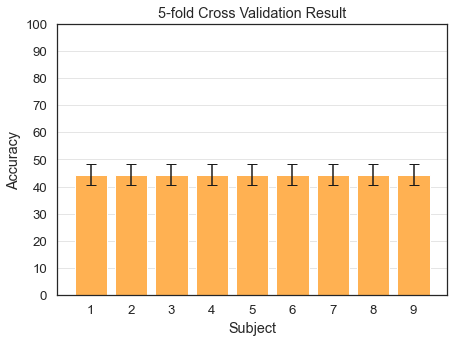

In [110]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, 10), model_acc, color="#ffb152", yerr=model_std, capsize=5)
ax.set(xticks=np.arange(1, 10), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Cross Validation Result')
ax.grid(axis='y', alpha=0.5)
plt.savefig('5fold_train_result.jpg')
plt.show()

In [111]:
# Key to access data
train = 'train'
feat_train = 'feat_train'
feat_test = 'feat_test'

# Blank list to store accuracy values
acc_train = []
acc_test = []

for i in range(1, ns):
    subj = subjectCounter(i)
    
    data_train = mod_data[subj][train][feat_train]
    X_train = data_train[:, :-1]
    y_train = data_train[:, -1]
    
    data_test = mod_data[subj][test][feat_test]
    X_test = data_test[:, :-1]
    y_test = data_test[:, -1]
    
    # Fit into model
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    acc_train.append(accuracy_score(y_true=y_train, y_pred=pred_train)*100)
    acc_test.append(accuracy_score(y_true=y_test, y_pred=pred_test)*100)

print(acc_train)
print(acc_test)

[56.49999999999999]
[50.0]


In [112]:
# Imports for Training and Testing Models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [119]:
def train_test(mod_data):
    train = 'train'
    feat_train = 'feat_train'
    feat_test = 'feat_test'
    
    for i in range(1, ns+1):
        subj = subjectCounter(i)
    
        data_train = mod_data[subj][train][feat_train]
        X_train = data_train[:, :-1]
        y_train = data_train[:, -1]
        
        data_test = mod_data[subj][test][feat_test]
        X_test = data_test[:, :-1]
        y_test = data_test[:, -1]

        # SVM
        svm_clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
        svm_clf.fit(X_train, y_train)

        y_pred = svm_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        print(subj)
        print("=========================================================================")
        # print(cm)
        print('Linear SVM Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")

        # SVM
        svm2_clf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))
        svm2_clf.fit(X_train, y_train)

        y_pred = svm2_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('RBF SVM Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")

        # RF
        rf_clf = RandomForestClassifier()
        rf_clf.fit(X_train, y_train)

        y_pred = rf_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('RF Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")


        # LDA
        lda_clf = LinearDiscriminantAnalysis()
        lda_clf.fit(X_train, y_train)

        y_pred = lda_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('LDA Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")


        # DT
        dt_clf = DecisionTreeClassifier()
        dt_clf = dt_clf.fit(X_train, y_train)

        y_pred = dt_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('DT Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")


        # NB
        nb = GaussianNB()
        nb.fit(X_train, y_train)

        y_pred = nb.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('NB Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")


        # KNN
        knn_clf = KNeighborsClassifier()
        knn_clf = knn_clf.fit(X_train, y_train)

        y_pred = knn_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('KNN Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        # print("=========================================================================")


        # AdaBoost
        adb_clf = AdaBoostClassifier()
        adb_clf = adb_clf.fit(X_train, y_train)

        y_pred = adb_clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print("=========================================================================")
        # print(cm)
        print('AdaBoost Accuracy: ' + str(accuracy_score(y_test, y_pred)*100) + '%')
        print('\nClassification Report : ')
        print(classification_report(y_test, y_pred))
        print("=========================================================================\n\n")

In [120]:
# For Subject 1
train_test(mod_data)

subject01
Linear SVM Accuracy: 50.0%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      1.00      0.67       300
         1.0       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

RBF SVM Accuracy: 50.0%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      1.00      0.67       300
         1.0       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

RF Accuracy: 50.0%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      1.00      0.67       300
         1.0       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

LDA Accuracy: 50.0%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      1.00      0.67       300
         1.0       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

DT Accuracy: 49.833333333333336%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      0.85      0.63       300
         1.0       0.49      0.15      0.23       300

    accuracy                    

c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

AdaBoost Accuracy: 50.16666666666667%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.50      0.94      0.65       300
         1.0       0.51      0.06      0.11       300

    accuracy                           0.50       600
   macro avg       0.51      0.50      0.38       600
weighted avg       0.51      0.50      0.38       600



subject02
Linear SVM Accuracy: 52.166666666666664%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.52      0.49      0.51       300
         1.0       0.52      0.55      0.53       300

    accuracy                           0.52       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.52      0.52      0.52       600

RBF SVM Accuracy: 57.666666666666664%

Classification Report : 
              precision    recall  f1-score   support

        -1.0       0.58      0.54      0.56       300
         1.0       0.57      0

In [190]:
# SCP_features_sub_1 = np.zeros((187500,4))
# SCP_features_sub_2 = np.zeros((187500,4))


# for j,_ in enumerate(mod_data['subject01'][EEG_red_pos_train]):
#     SCP_features_sub_1[mod_data['subject01'][EEG_red_pos_train][j]] = mod_data[subj][train][feat_red][j]
        
# for j,_ in enumerate(mod_data[subj][EEG_white_pos_train]):
#     SCP_features_sub_1[mod_data['subject01'][EEG_red_pos_train][j]] = mod_data[subj][train][feat_white][j]    
        
# for j,_ in enumerate(mod_data[subj][EEG_red_pos_test]):
#     SCP_features_sub_1[mod_data['subject01'][EEG_red_pos_test][j]] = mod_data[subj][test][feat_red][j]
        
# for j,_ in enumerate(mod_data[subj][EEG_white_pos_test]):
#     SCP_features_sub_1[mod_data['subject01'][EEG_white_pos_test][j]] = mod_data[subj][test][feat_white][j]    
    
    
    
    
    
# for j,_ in enumerate(mod_data['subject02'][EEG_red_pos_train]):
#     SCP_features_sub_2[mod_data['subject02'][EEG_red_pos_train][j]] = mod_data[subj][train][feat_red][j]
        
# for j,_ in enumerate(mod_data[subj][EEG_white_pos_train]):
#     SCP_features_sub_2[mod_data['subject02'][EEG_red_pos_train][j]] = mod_data[subj][train][feat_white][j]    
        
# for j,_ in enumerate(mod_data[subj][EEG_red_pos_test]):
#     SCP_features_sub_2[mod_data['subject02'][EEG_red_pos_test][j]] = mod_data[subj][test][feat_red][j]
        
# for j,_ in enumerate(mod_data[subj][EEG_white_pos_test]):
#     SCP_features_sub_2[mod_data['subject02'][EEG_white_pos_test][j]] = mod_data[subj][test][feat_white][j]    

In [219]:
# for i,_ in enumerate(SCP_features_sub_1):
#     for j,_ in enumerate(SCP_features_sub_1[i]):
#         if math.isnan(SCP_features_sub_1[i][j]):
#             SCP_features_sub_1[i][j] = 0.5
            
# for i,_ in enumerate(SCP_features_sub_2):
#     for j,_ in enumerate(SCP_features_sub_2[i]):
#         if math.isnan(SCP_features_sub_2[i][j]):
#             SCP_features_sub_2[i][j] = 0.5           

In [223]:
# print('sub_1_SCP_features_shape=',SCP_features_sub_1.shape)
# print(SCP_features_sub_1)

sub_1_SCP_features_shape= (187500, 4)
[[-0.57840092 -0.58173522 -0.72937747 -0.54128791]
 [-0.57811256 -0.5824584  -0.72990428 -0.54055362]
 [-0.57967449 -0.58263833 -0.7299591  -0.53892791]
 ...
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5       ]]


In [224]:
# print('sub_2_SCP_features_shape=',SCP_features_sub_2.shape)
# print(SCP_features_sub_2)

sub_2_SCP_features_shape= (187500, 4)
[[-0.57840092 -0.58173522 -0.72937747 -0.54128791]
 [-0.57811256 -0.5824584  -0.72990428 -0.54055362]
 [-0.57967449 -0.58263833 -0.7299591  -0.53892791]
 ...
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5       ]]


In [4]:
# !pip uninstall gumpy

^C


In [10]:
# !pip install git+https://github.com/gumpy-bci/gumpy

  Cloning https://github.com/gumpy-bci/gumpy to c:\users\anushka\appdata\local\temp\pip-req-build-snx9l7aj
  Resolved https://github.com/gumpy-bci/gumpy to commit abd8230dc50bd8b0a2348c6e08a1bba1c0ed3146
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/gumpy-bci/gumpy 'C:\Users\Anushka\AppData\Local\Temp\pip-req-build-snx9l7aj'


In [1]:
# sub_1_data_s = np.swapaxes(sub_1_data,2,1)

NameError: name 'np' is not defined

In [2]:
# epochs_train, epochs_test, y_train, y_test = gumpy.split.stratified_shuffle_Split(sub_1_data, labels, n_splits=10,test_size=0.2,random_state=0)

AttributeError: module 'gumpy' has no attribute 'split'